In [11]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix


In [12]:
data = pd.read_csv('/content/conflicts2_data.csv')

print("Sample data:")
print(data.head())

colors = sorted(set(data.values.flatten()))
color2idx = {c: i for i, c in enumerate(colors)}
idx2color = {i: c for c, i in color2idx.items()}
vocab_size = len(colors)

df_encoded = data.applymap(lambda x: color2idx[x])
sequences = df_encoded.values


Sample data:
   0  1  2  3  4  5  6  7  8  9  ...  30  31  32  33  34  35  36  37  38  39
0  2  2  0  3  0  1  1  1  0  1  ...   2   0   2   1   1   3   1   3   2   2
1  0  0  0  2  2  2  3  2  3  3  ...   1   1   1   1   3   3   3   3   0   0
2  3  1  1  1  1  1  0  0  0  2  ...   0   2   2   2   2   2   3   3   3   3
3  3  0  0  0  0  0  1  1  1  2  ...   3   1   0   1   0   2   3   3   3   3
4  3  3  0  2  1  0  2  1  1  3  ...   2   0   0   1   1   1   1   3   3   3

[5 rows x 40 columns]


<ipython-input-12-3d8a041f88e3>:14: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_encoded = data.applymap(lambda x: color2idx[x])


In [19]:
def corrupt_sequence(seq, mask_token):
    seq = seq.copy()
    color_to_mask = np.random.choice(seq)
    seq[seq == color_to_mask] = mask_token
    return seq

mask_token = vocab_size
vocab_size += 1

corrupted = np.array([corrupt_sequence(seq, mask_token) for seq in sequences])


In [20]:
X_train, X_test, y_train, y_test = train_test_split(corrupted, sequences, test_size=0.2, random_state=42)


In [21]:
class ColorSequencesDataset(Dataset):
    def __init__(self, inputs, targets):
        self.inputs = torch.tensor(inputs, dtype=torch.long)
        self.targets = torch.tensor(targets, dtype=torch.long)

    def __len__(self):
        return len(self.inputs)

    def __getitem__(self, idx):
        return self.inputs[idx], self.targets[idx]

train_ds = ColorSequencesDataset(X_train, y_train)
test_ds = ColorSequencesDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=64)


In [22]:
class DAE(nn.Module):
    def __init__(self, vocab_size, embed_dim=64, hidden_dim=128):
        super(DAE, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.encoder = nn.LSTM(embed_dim, hidden_dim, batch_first=True)
        self.decoder = nn.LSTM(hidden_dim, embed_dim, batch_first=True)
        self.output_layer = nn.Linear(embed_dim, vocab_size)

    def forward(self, x):
        x = self.embedding(x)
        encoded, _ = self.encoder(x)
        decoded, _ = self.decoder(encoded)
        out = self.output_layer(decoded)
        return out


In [23]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
seq_len = sequences.shape[1]
model = DAE(vocab_size).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 15
losses = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        loss = criterion(outputs.view(-1, vocab_size), targets.view(-1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)
    losses.append(avg_loss)
    print(f"Epoch {epoch+1}, Loss: {avg_loss:.4f}")


Epoch 1, Loss: 0.0891
Epoch 2, Loss: 0.0413
Epoch 3, Loss: 0.0408
Epoch 4, Loss: 0.0407
Epoch 5, Loss: 0.0406
Epoch 6, Loss: 0.0405
Epoch 7, Loss: 0.0404
Epoch 8, Loss: 0.0404
Epoch 9, Loss: 0.0403
Epoch 10, Loss: 0.0403
Epoch 11, Loss: 0.0403
Epoch 12, Loss: 0.0403
Epoch 13, Loss: 0.0403
Epoch 14, Loss: 0.0402
Epoch 15, Loss: 0.0402


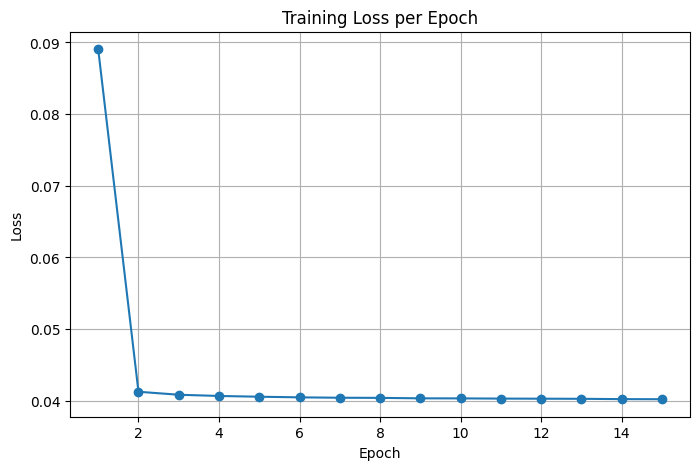

In [24]:
plt.figure(figsize=(8,5))
plt.plot(range(1, epochs+1), losses, marker='o')
plt.title("Training Loss per Epoch")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [25]:
model.eval()
correct = 0
total = 0
all_preds, all_targets, all_inputs = [], [], []

with torch.no_grad():
    for inputs, targets in test_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        preds = torch.argmax(outputs, dim=-1)

        correct += (preds == targets).sum().item()
        total += targets.numel()

        all_preds.extend(preds.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())
        all_inputs.extend(inputs.cpu().numpy())

print(f"\nTest Accuracy: {correct / total:.4f}")



Test Accuracy: 0.9795


In [29]:
def decode_sequence(seq, idx2color):
    return [int(idx) if idx in idx2color else '[MASK]' for idx in seq]

num_examples = 5
for i in range(num_examples):
    original = decode_sequence(all_targets[i], idx2color)
    corrupted = decode_sequence(all_inputs[i], idx2color)
    predicted = decode_sequence(all_preds[i], idx2color)

    print(f"\nExample {i+1}")
    print(f"Original : {original}")
    print(f"Corrupted: {corrupted}")
    print(f"Predicted: {predicted}")



Example 1
Original : [1, 1, 1, 1, 0, 3, 3, 3, 0, 2, 2, 0, 1, 1, 0, 0, 3, 3, 0, 2, 1, 2, 2, 3, 3, 2, 3, 1, 1, 2, 1, 0, 3, 0, 0, 0, 2, 2, 2, 2]
Corrupted: [1, 1, 1, 1, 0, '[MASK]', '[MASK]', '[MASK]', 0, 2, 2, 0, 1, 1, 0, 0, '[MASK]', '[MASK]', 0, 2, 1, 2, 2, '[MASK]', '[MASK]', 2, '[MASK]', 1, 1, 2, 1, 0, '[MASK]', 0, 0, 0, 2, 2, 2, 2]
Predicted: [1, 1, 1, 1, 0, 2, 2, 2, 0, 2, 2, 0, 1, 1, 0, 0, 3, 3, 0, 2, 1, 2, 2, 3, 3, 2, 3, 1, 1, 2, 1, 0, 3, 0, 0, 0, 2, 2, 2, 2]

Example 2
Original : [0, 0, 0, 0, 2, 3, 3, 3, 3, 0, 1, 1, 2, 0, 1, 2, 2, 3, 3, 3, 1, 3, 1, 1, 0, 0, 1, 0, 0, 2, 3, 2, 2, 1, 1, 2, 1, 3, 3, 0]
Corrupted: [0, 0, 0, 0, 2, '[MASK]', '[MASK]', '[MASK]', '[MASK]', 0, 1, 1, 2, 0, 1, 2, 2, '[MASK]', '[MASK]', '[MASK]', 1, '[MASK]', 1, 1, 0, 0, 1, 0, 0, 2, '[MASK]', 2, 2, 1, 1, 2, 1, '[MASK]', '[MASK]', 0]
Predicted: [0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 1, 1, 2, 0, 1, 2, 2, 3, 3, 3, 1, 3, 1, 1, 0, 0, 1, 0, 0, 2, 3, 2, 2, 1, 1, 2, 1, 3, 3, 0]

Example 3
Original : [0, 0, 1, 2, 1, 1, 3, 3,

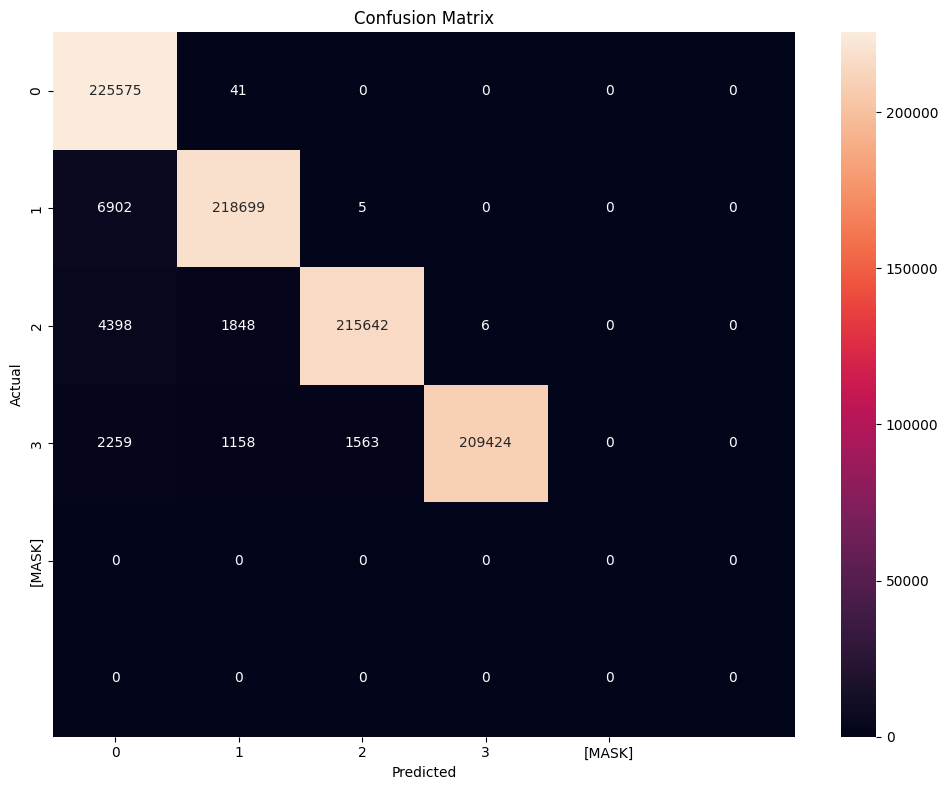

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

flat_preds = np.array(all_preds).reshape(-1)
flat_targets = np.array(all_targets).reshape(-1)

cm = confusion_matrix(flat_targets, flat_preds, labels=list(range(vocab_size)))

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d',
            xticklabels=colors + ['[MASK]'],
            yticklabels=colors + ['[MASK]'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()


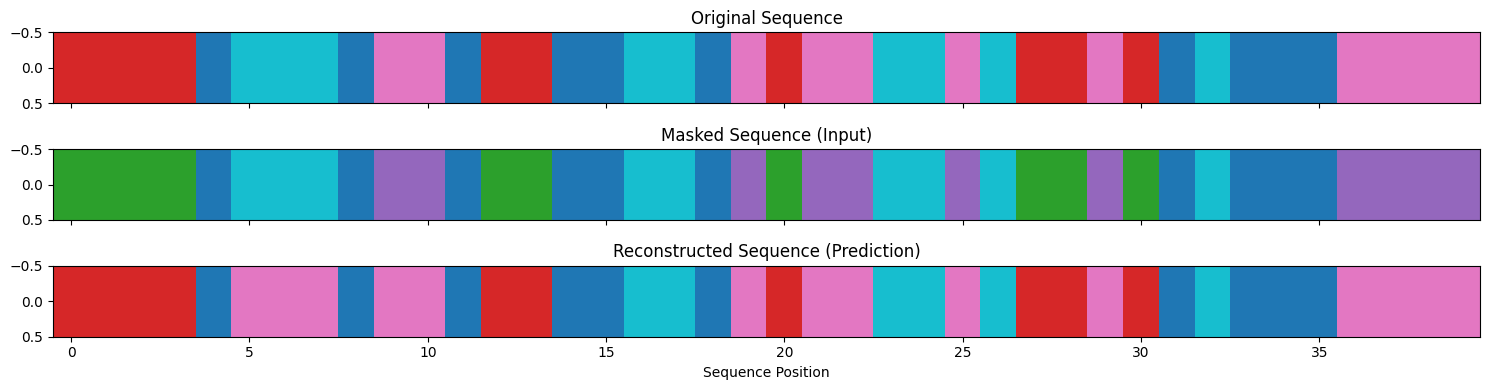

In [28]:
import matplotlib.pyplot as plt

def visualize_example(index=0):
    original = all_targets[index]
    corrupted = all_inputs[index]
    predicted = all_preds[index]

    fig, axs = plt.subplots(3, 1, figsize=(15, 4), sharex=True)
    axs[0].imshow([original], cmap='tab10', aspect='auto')
    axs[0].set_title('Original Sequence')

    axs[1].imshow([corrupted], cmap='tab10', aspect='auto')
    axs[1].set_title('Masked Sequence (Input)')

    axs[2].imshow([predicted], cmap='tab10', aspect='auto')
    axs[2].set_title('Reconstructed Sequence (Prediction)')

    plt.xlabel("Sequence Position")
    plt.tight_layout()
    plt.show()

visualize_example(0)
